<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Hate Speech Detector

Today you are a machine learning engineer, a member of the Birdwatch at Twitter. 

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, a tweet contains hate speech if it has a racist or sexist sentiment associated with it. In other words, we need to classify racist or sexist tweets from other tweets.

A labelled dataset of 31,962 tweets (late 2017 to early 2018) is provided in the form of a compressed csv file with each line storing a tweet id, its label, and the tweet. Label '1' denotes the tweet is racist/sexist while label '0' denotes the tweet is not racist/sexist.

We will first approach the problem in a traditional approach: clean the raw text using simple regex (regular expression), extract features, build a naive Bayes models to classify tweets; then we build a deep learning model and explain our deep learning model with LIME.

## 📚 Learning Objectives

By the end of this lesson, you will be able to:

- Understand the basic concepts in natural language processing (NLP)
- Perform basic NLP tasks on text, e.g., tweets
- Build a naive Bayes classifier to detect hate speech 
- Build a bidirectional long short-term memory (BiLSTM) to detect hate speech
- Visualize embeddings with Tensorboard embedding projector
- Explain models with LIME

# Task I: Data Preprocessing


1. Install dependencies.

    Most modules are pre-installed in Colab, however, we need to update `gensim` to its recent version and install `lime`.

In [468]:
!pip install -U -q gensim==4.2.0 lime

2. Connect Colab to your local Google Drive.

In [469]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [470]:
import pandas as pd

3. Use `pandas.read_csv` to load the tweets in `tweets.csv.gz` and save the `pd.DataFrame` into `raw`. Make sure the path points to where the data is located in your Google Drive. 

In [471]:
# YOUR CODE HERE
raw = pd.read_csv('/content/drive/MyDrive/fourthbrain/dat/tweets.csv.gz')

In [472]:
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


In [473]:
raw.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

4. Sample 5 random tweets from the dataset for each label and display `label` and `tweet` columns. 
Hint: one option is to use `sample()` followed by `groupby`. 

In [474]:
# Colab includes an extension that renders pandas dataframes into interactive displays that can be filtered, sorted, and explored dynamically.
from google.colab import data_table
data_table.enable_dataframe_formatter() 

# YOUR CODE HERE
raw.groupby('label').sample(5)


id  label                                              tweet
2292    2293      0  i wish i would've found @user months ago! goin...
9845    9846      0  another #melbourne snap, this guy played the m...
7994    7995      0  i just ... gosh.. i hate people... i hate the ...
13004  13005      0  another beautiful creature loses its life for ...
250      251      0   @user happy at w.ork conference: right mindse...
3169    3170      1  work out the idea of creating a substantive ar...
5445    5446      1  @user @user in atlanta the  mayor &amp; police...
17490  17491      1  this video was censored by youtube  for "hate ...
4616    4617      1  chaplin - the dictator speech  via @user  #the...
11804  11805      1  how about a qualifications trc, professor bozz...

5. The tweets are in English and all words should be already in lowercase. 
Now calculate the number of characters in each tweet and assign the values to a new column `len_tweet` in `raw`. 

In [475]:
# YOUR CODE HERE
raw['len_tweet'] = raw.tweet.str.len()

6. What are the summary statistics of `len_tweet` for each label? 
Hint: use `groupby` and `describe`. 

In [476]:
pd.set_option("display.precision", 1)

# YOUR CODE HERE
raw.groupby('label')['len_tweet'].describe()

count  mean   std   min   25%   50%    75%    max
label                                                     
0      29720.0  84.3  29.6  11.0  62.0  88.0  107.0  274.0
1       2242.0  90.2  27.4  12.0  69.0  96.0  111.0  152.0

Note we have an imbalanced dataset: the ratio of non-hate speech to hate speech is roughly 13:1. 

7. Clean the tweets. 

    We use `re` to perform basic text manipulations. 
    Specically, remove anonymized user handle, remove numbers and special characters except hashtags.

In [477]:
import re

8. Remove user handles from the text in `tweet`, or anything directly following the symbols `@`, and save the resulting tweets to a new column `tidy_tweet` in `raw`. 
    
    Hint: you can use `re.sub` on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tweet']`.

In [478]:
raw['tidy_tweet'] = raw.tweet.apply(lambda x: re.sub('@[\w]*', '', string=x)) # YOUR CODE HERE
raw.sample(5, random_state=203)

id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   

       len_tweet                                         tidy_tweet  
790          109   and you keep telling that only aryans are all...  
21928         25                                 what makes you  ?   
25642        101   â #nzd/usd extends rbnz-led rally, hits fre...  
20436         91  i'm on a mission to ride all of the animals!  ...  
22552         88  the color of a human skin matters a lot to the...

9. Remove non-alphabetic characters yet keep symbols `#` from `tidy_tweet` and save the result in `tidy_tweet`. 
In other words, keep all 26 letters and `#`.

    Note: in some applications, punctuations, emojis, or whether the word is in all caps can be of use. 
    You shall decide whether to extract such features for the application and perform error analysis to gain insight. 

In [479]:
raw['tidy_tweet'] = raw.tidy_tweet.apply(lambda x: re.sub('[^a-zA-Z#]', ' ', string=x)) # YOUR CODE HERE
raw.sample(5, random_state=203)

id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   

       len_tweet                                         tidy_tweet  
790          109   and you keep telling that only aryans are all...  
21928         25                                 what makes you      
25642        101       #nzd usd extends rbnz led rally  hits fre...  
20436         91  i m on a mission to ride all of the animals   ...  
22552         88  the color of a human skin matters a lot to the...

10. Remove words that is shorter than 4 characters from the processed tweets.

    For example, 
      
    `i m on a mission to ride all of the animals #teamchanlv #vegas #lasvegas #funtimes`
      
    will be reduced to 
      
    `mission ride animals #teamchanlv #vegas #lasvegas #funtimes`


In [480]:
raw['tidy_tweet'] = raw.tidy_tweet.apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4])) # YOUR CODE HERE
raw.sample(5, random_state=203)

id  label                                              tweet  \
790      791      1  @user and you keep telling that only aryans ar...   
21928  21929      0                           @user what makes you  ?    
25642  25643      0   â #nzd/usd extends rbnz-led rally, hits fre...   
20436  20437      0  i'm on a mission to ride all of the animals!  ...   
22552  22553      0  the color of a human skin matters a lot to the...   

       len_tweet                                         tidy_tweet  
790          109  keep telling that only aryans allowed rape wom...  
21928         25                                         what makes  
25642        101  #nzd extends rbnz rally hits fresh year high n...  
20436         91  mission ride animals #teamchanlv #vegas #lasve...  
22552         88  color human skin matters system when comes jud...

11. Remove stopwords and perform text normalization. 
    
    We will use `stopwords` collection and `SnowballStemmer` in `nltk` for this task. Before doing so, we need to tokenize the tweets. 
    Tokens are individual terms or words, and tokenization is simply to split a string of text into tokens. 
    You can use [`str.split()`](https://docs.python.org/3/library/stdtypes.html#str.split) on individual text and [`apply`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) a simple lambda function for the series `raw['tidy_tweet']` and save the result into `tokenized_tweet`. 
    
    Check out some methods for the built-in type `str` [here](https://docs.python.org/3/library/stdtypes.html#string-methods).

In [481]:
tokenized_tweet = raw.tidy_tweet.str.split() # YOUR CODE HERE
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

12. Extract stop words and remove them from the tokens.

    Note: depending on the task / industry, it is highly recommended that one curate custom stop words. 

In [482]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [483]:
tokenized_tweet = tokenized_tweet.apply(lambda words: [word for word in words if word not in stop_words]) # YOUR CODE HERE

In [484]:
tokenized_tweet.head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, cause, offer, wheelcha...
2                                    [bihday, majesty]
3                           [#model, love, take, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [485]:
assert any(word in tokenized_tweet for word in stop_words) == False

13. Create a new instance of a language specific [`SnowballStemmer`](https://www.nltk.org/api/nltk.stem.snowball.html), set the `language` to be "english"; see [how to](https://www.nltk.org/howto/stem.html). 

In [486]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english') # YOUR CODE HERE

In [487]:
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [father, dysfunct, selfish, drag, kid, dysfunc...
1    [thank, #lyft, credit, caus, offer, wheelchair...
2                                    [bihday, majesti]
3                           [#model, love, take, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

14. Lastly, let's stitch these tokens in `tokenized_tweet` back together and save them in `raw['tidy_tweet']`. 
Use [`str.join()`](https://docs.python.org/3/library/stdtypes.html#str.join) and `apply`.

In [488]:
raw['tidy_tweet'] = tokenized_tweet.str.join(' ') # YOUR CODE HERE

# Task 2. Wordcloud and Hashtag

In this task, we want to gain a general idea of what the common words were and how hashtags were used in tweets. 
We will create wordclouds and extract the top hashtags used in each label. 

1. Before doing so, out of caution of possible data leakage, split the `raw['tidy_tweet']` into training and test datasets in a stratified fashion, set the test size at .25 and random state as 42.
    
    Save the results into `X_train`, `X_test`, `y_train`, and `y_test`.

In [489]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    raw['tidy_tweet'], raw.label, 
    test_size=0.25, random_state=42, stratify=raw.label)

In [490]:
assert X_train.shape == y_train.shape == (23971, )
assert X_test.shape == y_test.shape == (7991,)

2. A word cloud is a cluster of words depicted in different sizes. 
The bigger the word appears, the more often it appears in the given text. 
It can offer an easy visual presentation to reveal the theme of a topic. 

    Function `plot_wordcloud` is provided to plot 50 most frequent words from the given text in the shape of twitter's logo. 
    You may need to replace the image path accordingly.

In [491]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_wordcloud(text:str) -> None:
    '''
    Plot a wordcloud of top 50 words from the input text
    masked by twitter logo
    '''
    mask = np.array(Image.open('/content/drive/MyDrive/fourthbrain/img/twitter-mask.png')) # REPLACE w/ YOUR FILE PATH
    wordcloud = WordCloud( 
        background_color='white', 
        random_state=42,
        max_words=50, 
        max_font_size=80, 
        mask = mask).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

3. Visualize the wordcloud. 

    The function expects one long string. 
    Stitch all tidy tweets from training set and save the single string to `all_words`, then visualize the wordcloud for all the words.

In [492]:
all_words = ' '.join(X_train.str.split().sum()) # YOUR CODE HERE

In [493]:
all_words

'like spread peanut butter white bread #littlewond watch made america simpson interest went still go franci underwood seen leav marseill #nojok #enjoy #music #today #free #app #free #music #juic experi #notsobad #healthyliv #eatclean #fit #cook #yummi #mamasgotanewtoy filter need time sean gaoth dobhair #cultur #culinari #experi #friend #lovetravel show hide #photo #mask #folkgood #show #hide #charact #face #mask fuck fuck bitch real simpleton figur place first order three flavour #lovecoconut #cuppanutt bihday babi #gemini bihday june came pmet youth parliament #democraci listen free went club tonight safe fuck miss town thotsdal realli happi work confer right mindset lead cultur develop organ #work #mindset reaction #san poster #wow #killer #love #fathersday #greatest #dad #ever #thankyou thank #cloudchas bull hill climb reach target complet task surviv strong lularo feel happi look happi make happi click link #nigga #even anymor love favourit item cloth #comfi undoubt islamist post 

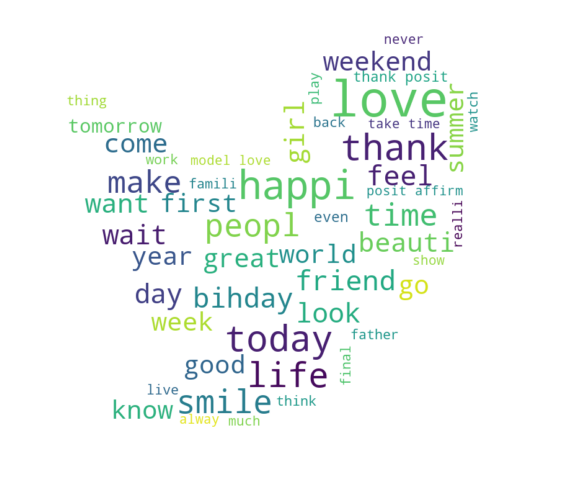

In [494]:
plot_wordcloud(all_words)

4. Visualize the wordcloud just for the text from the tweets identified as hate speech. 

    Similarly, you need to stitch all the tidy tweets in training set that were identified as hate speech. 
    Save the long string to `negative_words`.

In [495]:
negative_words =  ' '.join(X_train[y_train == 1].str.split().sum()) # YOUR CODE HERE

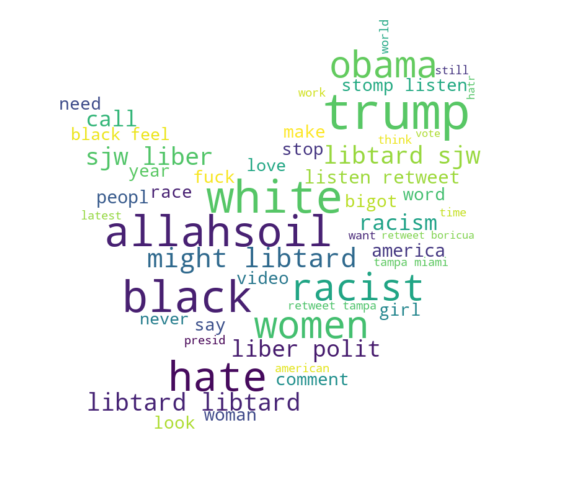

In [496]:
plot_wordcloud(negative_words)

5. Hashtag is a feature for tweets and we would like to inspect if hashtags provide information for our classification task. 

    Function `hashtag_extract` is provided to extract hastags from an iterable (list or series) and return the hashtags in a list. 

In [497]:
def hashtag_extract(x) -> list:
    """
    extract hastags from an iterable (list or series) and 
    return the hashtags in a list.
    """
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

6. Extract hashtags from non-hate speech tweets.

In [498]:
HT_regular = hashtag_extract(X_train[y_train == 0]) # YOUR CODE HERE

In [499]:
assert type(HT_regular) == list
assert type(HT_regular[0]) == list # nested list

7. Now extract hashtags from hate speech tweets.

In [500]:
HT_negative = hashtag_extract(X_train[y_train == 1]) # YOUR CODE HERE

8. Both `HT_regular` and `HT_negative` are nested lists, so use the following trick to unnest both lists.

In [501]:
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [502]:
assert type(HT_regular) == type(HT_negative) == list
assert type(HT_regular[0]) == type(HT_negative[0]) == str

9. Complete the function `top_hashtags` below to take a list of hashtags and return the top `n` hashtag keyword and its frequncy. 

In [503]:
from typing import List, Tuple
from collections import Counter
def top_hashtags(hashtags:List[str], n=10) -> List[Tuple[str, int]]:
    ''' Function to return the top n hashtags '''
    # YOUR CODE HERE
    return_list = list(Counter(hashtags).items())
    return_list.sort(key=lambda x: x[1], reverse=True)
    return return_list[:n]

1. Apply the function to the hashtag lists from the non-hate speech tweets and the hate speech tweets.

In [504]:
# YOUR CODE HERE
top_hashtags(HT_regular)

[('love', 1245),
 ('posit', 693),
 ('smile', 514),
 ('healthi', 423),
 ('thank', 398),
 ('fun', 345),
 ('life', 329),
 ('affirm', 324),
 ('summer', 291),
 ('model', 284)]

In [505]:
# YOUR CODE HERE
top_hashtags(HT_negative)

[('trump', 97),
 ('allahsoil', 77),
 ('polit', 73),
 ('liber', 62),
 ('libtard', 57),
 ('sjw', 56),
 ('retweet', 50),
 ('miami', 37),
 ('black', 36),
 ('hate', 28)]

10. DISCUSS: are these hashtags making sense? should we include them as features or should we strip the # before tokenizing (that is, treat "#love" the same as "love")? why and why not?
          They make perfect sense to me. I would definitely include them as features, since some are far more likely to be used in positive or negative contexts.

# Task 3. Features

Note that almost all the machine learning related Python modules expect numerical presentation of data; thus we need to transform our text first.
We will experiment with bag of words, tf-idf, and word2vec.  

1. Convert the collection of text documents to a matrix of token counts.

    Check the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 
    
    Create an instance of `CountVectorizer` named `bow_vectorizer`, set `max_features` to be `MAX_FEATURES`.
    Learn the vocabulary dictionary and return document-term matrix and save it to `bow_train`. Use `.fit_transform`. 

In [506]:
from sklearn.feature_extraction.text import CountVectorizer
MAX_FEATURES = 1000


bow_vectorizer = CountVectorizer(max_features=MAX_FEATURES) # YOUR CODE HERE
bow_train = bow_vectorizer.fit_transform(X_train) # YOUR CODE HERE

In [507]:
assert bow_train.shape == (X_train.shape[0], MAX_FEATURES)

2. Print the first three rows from `bow_train`. Hint: `.toarray()`.

In [508]:
# YOUR CODE HERE
bow_train.toarray()[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [509]:
from scipy.sparse.csr import csr_matrix
assert type(bow_train) == csr_matrix

3. Similarly, convert the collection of text documents to a matrix of TF-IDF features.
    
    Create an instance of [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) named `tfidf_vectorizer`, set `max_features` to be `MAX_FEATURES`.

    Learn the vocabulary and idf, return document-term matrix and save it to `tfidf_train`. 

In [510]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [511]:
tfidf_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES, stop_words='english')  # YOUR CODE HERE
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [512]:
assert type(tfidf_train) == csr_matrix
assert tfidf_train.shape == bow_train.shape == (X_train.shape[0], MAX_FEATURES)

4. Extract word embeddings using Word2Vec. 
We will use [`gensim`](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for this task. 
    
    The Word2Vec model takes either a list of lists of tokens or an iterable that streams the sentences directly from disk/network. 
    Here, we tokenize the tidy tweets in `X_train` and save the list (`pd.series`) of lists of tokens to `tokenized_tweet`. 

In [513]:
tokenized_tweet =  tokenized_tweet = X_train.str.split() # YOUR CODE HERE

In [514]:
assert tokenized_tweet.shape == X_train.shape

In [515]:
tokenized_tweet.head()

1036     [like, spread, peanut, butter, white, bread, #...
2380     [watch, made, america, simpson, interest, went...
31605    [franci, underwood, seen, leav, marseill, #nojok]
23437    [#enjoy, #music, #today, #free, #app, #free, #...
2669     [#juic, experi, #notsobad, #healthyliv, #eatcl...
Name: tidy_tweet, dtype: object

5. Import `Word2Vec` from `gensim.models`; see [doc](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). 

    Create a skip-gram `Word2Vec` instance named `w2v` that learns on the `tokenized_tweet`, with `vector_size` set at `MAX_FEATURES`, and other parameters are provided. 

In [516]:
from gensim.models import Word2Vec

In [517]:
w2v = Word2Vec(
        # YOUR CODE HERE
        sentences=tokenized_tweet,
        vector_size=MAX_FEATURES,
        # YOUR CODE HERE
        window=5, min_count=2, sg = 1, 
        hs = 0, negative = 10,  workers= 2, 
        seed = 34)

6. Train the skip-gram model, set the epochs at 20.

In [518]:
%%time
# YOUR CODE HERE
w2v.train(tokenized_tweet, epochs=20, total_examples=w2v.corpus_count)


CPU times: user 1min 34s, sys: 110 ms, total: 1min 34s
Wall time: 50.3 s


(2736891, 3222020)

7. Let's see how the model performs. 
Specify a word and print out the 10 most similar words from the our tweets in the training set. 
Use [`most_similar`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). 
Hint: print the type of `w2v` and `w2v.wv`.

In [519]:
# YOUR CODE HERE
w2v.wv.most_similar('man')

[('elsewher', 0.761949360370636),
 ('ceifi', 0.7228103876113892),
 ('abroad', 0.7171475887298584),
 ('#topoli', 0.7091783881187439),
 ('tribal', 0.7077023386955261),
 ('#arsen', 0.701984167098999),
 ('merri', 0.6980411410331726),
 ('#homedepot', 0.6970736980438232),
 ('thump', 0.6941474676132202),
 ('jail', 0.6921247839927673)]

8. Discuss: how does w2v calculate the similarities? 

  W2v uses cosine similarity, where it measures how orthogonal two vectors are, where the less orthogonal, the more similar.

9. Discuss: do you think Word2Vec is supervised or unsupervised ML technique?

    It's unsupervised, because it doesn't depend on labels, it just groups words based on similarity of context and usage.

10. Engineer features. 

    For each tweet, we calculate the average of embeddings (function `word_vector`) and then apply it to every tidy tweet in `X_train` (use function `tokens_to_array`).
    Both functions are provided, inspect the code and save the features in `w2v_train`.

In [520]:
from gensim.models.keyedvectors import KeyedVectors

def word_vector(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += keyed_vec[word].reshape((1, size))
            count += 1
        except KeyError: 
            # handling the case where the token is not in vocabulary        
            continue
    if count != 0:
        vec /= count
    return vec

def tokens_to_array(tokens:list, size:int, keyed_vec:KeyedVectors= w2v.wv):
    array = np.zeros((len(tokens), size))
    for i in range(len(tokens)):
        array[i,:] = word_vector(tokens.iloc[i], size, keyed_vec=keyed_vec)
    return array

In [521]:
w2v_train = tokens_to_array(X_train, MAX_FEATURES) # YOUR CODE HERE

In [522]:
assert w2v_train.shape == (X_train.shape[0], MAX_FEATURES)

11. Prepare the test data before modeling for each approach:


  - extract features from `X_test` using the bag of words approach; use `bow_vectorizer`
  - extract features from `X_test` using the tf-idf approach; use `tfidf_vectorizer`
  - extract features from `X_test` using Word2Vec embeddings; you need to first tokenized the tidy tweets in `X_test`, then convert the tokens to array of shape `(X_test.shape[0], MAX_FEATURES)`.

In [523]:
bow_test = bow_vectorizer.transform(X_test) # YOUR CODE HERE
tfidf_test = tfidf_vectorizer.transform(X_test) # YOUR CODE HERE
tokenized_tweet_test = X_test.apply(lambda x: x.split()) # YOUR CODE HERE
w2v_test = tokens_to_array(tokenized_tweet_test, MAX_FEATURES, keyed_vec=w2v.wv) # YOUR CODE HERE

In [524]:
assert bow_test.shape == tfidf_test.shape == w2v_test.shape == (X_test.shape[0], MAX_FEATURES)

# Task 4. Naive Bayes classifiers

In this task, you will build a [naive Bayes](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html) (here's another [ref](https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf)), classifiers to identify the hate speech tweets using different sets of features from the last task, and evaluate their performances. 

In the era of deep learning, naive Bayes is useful due to its simplicity and reasonable performance, especially if there is not much training data available. A common interview question is "Why is naive Bayes naive?". 

We will use multi-variate Bernoulli naive Bayes [`BernoulliNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html); try other flavors of [naive Bayes](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) if time permits. Code is pretty straightforward. 

1. Import `BernoulliNB` for modeling and `classification_report` for reporting performance. 

In [525]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

2. Create an instance of  `BernoulliNB` named `BNBmodel`. 

    We can use it for all three feature sets.

In [526]:
BNBmodel = BernoulliNB() # YOUR CODE HERE

3. Train the multi-variate Bernoulli naive Bayes using bag of words features and print the performance report.

In [527]:
BNBmodel.fit(bow_test, y_test) # YOUR CODE HERE (train the model)

BernoulliNB()

In [528]:
print(classification_report(BNBmodel.predict(bow_test), y_test)) # YOUR CODE HERE (report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7536
           1       0.51      0.63      0.57       455

    accuracy                           0.94      7991
   macro avg       0.75      0.80      0.77      7991
weighted avg       0.95      0.94      0.95      7991



4. Similarly, train the model using tf-idf features and print the performance report. 

    Is the performance expected? Why or why not?

In [529]:
BNBmodel.fit(tfidf_test, y_test) # YOUR CODE HERE

BernoulliNB()

In [530]:
print(classification_report(BNBmodel.predict(tfidf_test), y_test)) # YOUR CODE HERE

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7556
           1       0.50      0.64      0.56       435

    accuracy                           0.94      7991
   macro avg       0.74      0.80      0.76      7991
weighted avg       0.95      0.94      0.95      7991



5. Finally, train the model using Word2Vec embeddings and report the performance. 

In [531]:
# YOUR CODE HERE
BNBmodel.fit(w2v_test, y_test)
# YOUR CODE HERE
print(classification_report(BNBmodel.predict(w2v_test), y_test))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      6437
           1       0.82      0.30      0.43      1554

    accuracy                           0.85      7991
   macro avg       0.84      0.64      0.67      7991
weighted avg       0.85      0.85      0.82      7991



In [532]:
preds = BNBmodel.predict(w2v_test)
for x, y in zip(X_test[y_test != preds].head(), y_test.head()):
  print(x, ' ', y)

mate address argument rather #troll #staup #rude   0
surpris read make betray #scifi #kindleunlimit   0
world turn polit zoolog disast govern truli ever learn   0
#chroniclescontinu moment steal favorit color ask #what   0
cannot imagin shoe local enforc first respond #orlando prayer   0


6. Discuss the differences in performace using tf-idf vs skim-gram embeddings. 

    The performance was extremely similar, with tf-idf having a slight edge in recall and a slight disadvantage elsewhere.

7. Examine a few tweets where the model(s) failed. 
What other features would you include in the next iteration?

    I would include several columns other than we have here. For example:
    - Length of tweet
    - Number of hashtags
    - Who it was directed towards
    - Whether it was a reply or original tweet

# Task 5. Bidirectional LSTM 

In this task, you will build a bidirectional LSTM (BiLSTM) model to detect tweets identified as hate speech, and visualize the embedding layer using Tensorboard projector. 

Why BiLSTM? LSTM, at its core, preserves information from inputs that has already passed through it using the hidden state. Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. BiLSTMs run inputs in both ways, one from past to future and one from future to past and show very good results as they can understand context better [ref](https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm).

1. Tokenizing and padding. 
    
    As LSTM expects every sentence to be of the same length, in addition to [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with a given number of vocabulary `VOCAB_SIZE`, we need to [pad](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) shorter tweets with 0s until the length is `MAX_LEN` and truncate longer tweets to be exact `MAX_LEN` long. 
    
   Function `tokenize_pad_sequences` is provided except that you need to supply correct `num_words` and `filters`; do NOT filter `#`. 
   
   We feed the processed `tidy_tweet` to `tokenize_pad_sequences`, but one can perform the preprocessing steps in `Tokenizer` and apply it directly on the raw tweets.

In [533]:
VOCAB_SIZE = 25000  
MAX_LEN = 50

In [534]:
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

def tokenize_pad_sequences(text):
    '''
    tokenize the input text into sequences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(
        num_words= VOCAB_SIZE, # YOUR CODE HERE
        filters= '[^a-zA-Z#]', # YOUR CODE HERE
        lower=True, split=' ', oov_token='oov')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=MAX_LEN)

    return X, tokenizer

In [535]:
print('Before Tokenization & Padding \n', raw['tidy_tweet'][0])
X, tokenizer = tokenize_pad_sequences(raw['tidy_tweet'])
print('After Tokenization & Padding \n', X[0])
y = raw['label'].values

Before Tokenization & Padding 
 father dysfunct selfish drag kid dysfunct #run
After Tokenization & Padding 
 [   9   34 4518 1809  229   19  185 4518  330    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


2. Let's split `X` into training and testing datasets, save 25% for testing. 
Then split training dataset into training and validation datasets, with 20% for validation. 
Set both `random_state` to be 42. 
Stratify both splits. 

In [536]:
X_train, X_test, y_train, y_test = train_test_split(
    # YOUR CODE HERE
    X, y, random_state=42
    )
X_train, X_val, y_train, y_val = train_test_split(
    # YOUR CODE HERE
    X_train, y_train, random_state=42
    )

In [537]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (17978, 50) (17978,)
Validation Set -> (5993, 50) (5993,)
Test Set -> (7991, 50) (7991,)


3. Now build a sequential model:

    - an embedding layer
    - a bidirectional LSTM with 32 units and set `return_sequences=True` in LSTM
    - a global average pooling operation for temporal data
    - a dropout layer with 20% rate
    - a dense layer of 32 units and set the activation function to be ReLu
    - a dense layer of 1 unit and set the proper activation function for classification

In [538]:
from keras.models import Sequential
# YOUR CODE HERE (layer imports)
from keras import layers
EMBEDDING_DIM = 16   
model = Sequential([
    # YOUR CODE HERE
    layers.Embedding(input_dim=EMBEDDING_DIM, output_dim=32),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [539]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          512       
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 64)         16640     
 nal)                                                            
                                                                 
 global_average_pooling1d_7   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                

4. Compile the model. 

    Fill in a proper loss function and use adam as the optimizer. 
    For metrics, include precision and recall in the metrics, in addition to accuracy. 

In [540]:
from keras.metrics import Precision, Recall
model.compile(
    loss='binary_crossentropy', # YOUR CODE HERE
    optimizer='adam', 
    metrics= [Precision(), Recall(), 'accuracy']# YOUR CODE HERE]
    ) 

5. Train the model for 10 epochs on training dataset with a  validation set.

In [541]:
EPOCHS=10
BATCH_SIZE = 32
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), # YOUR CODE HERE
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2)

Epoch 1/10
562/562 - 11s - loss: 0.2567 - precision_8: 0.1429 - recall_8: 8.0580e-04 - accuracy: 0.9307 - val_loss: 0.2456 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_accuracy: 0.9262 - 11s/epoch - 19ms/step
Epoch 2/10
562/562 - 6s - loss: 0.2359 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - accuracy: 0.9310 - val_loss: 0.2438 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_accuracy: 0.9262 - 6s/epoch - 11ms/step
Epoch 3/10
562/562 - 6s - loss: 0.2343 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - accuracy: 0.9310 - val_loss: 0.2420 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_accuracy: 0.9262 - 6s/epoch - 11ms/step
Epoch 4/10
562/562 - 6s - loss: 0.2324 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - accuracy: 0.9310 - val_loss: 0.2444 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_accuracy: 0.9262 - 6s/epoch - 11ms/step
Epoch 5/10
562/562 - 6s - loss: 0.2318 - precision_8: 0.0000e+00 - recall_8: 0.0000e+0

6. Function `plot_graphs` is provided below to visualize how the performance of model progresses as a function of epoch. 

    Visualize accuracy and loss. 

In [542]:
def plot_graphs(history, metric):
  fig, ax = plt.subplots()
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  ax.set_xticks(range(EPOCHS))
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

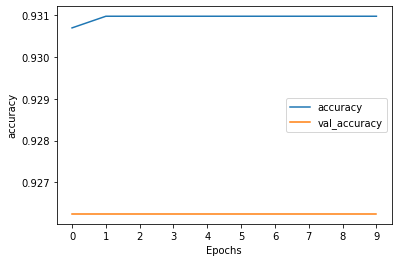

In [543]:
# YOUR CODE HERE
plot_graphs(history, 'accuracy')

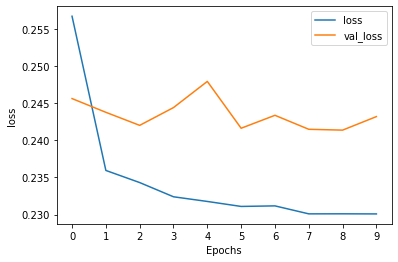

In [544]:
# YOUR CODE HERE
plot_graphs(history, 'loss')

7. The model starts to overfit after a couple of epochs. 
Consider using [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop training when a monitored metric has stopped improving. 

  What can we do to tame overfitting?

    As noted above, one option is early stopping. Another option is to increase dropout layers, use less layers overall, make the layers narrowerer, or reduce the feature space.

8. Print the classification report of the model on test dataset. 

In [545]:
# YOUR CODE HERE
preds = model.predict(X_test)
print(classification_report(preds.round(), y_test))

250/250 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      7991
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      7991
   macro avg       0.50      0.47      0.48      7991
weighted avg       1.00      0.93      0.96      7991



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [546]:
preds

array([[0.00264792],
       [0.00312693],
       [0.21428342],
       ...,
       [0.01729208],
       [0.21784921],
       [0.00559905]], dtype=float32)

9. Discuss: how does the BiLSTM model improve the classification over naive Bayes? 

    Mine didn't. It did really bad, and only predicted class 0. I'm sure this is user error, and not the result of the way the model works.

In [547]:
# # NB using tf-idf
#               precision    recall  f1-score   support

#            0       0.96      0.97      0.97      7430
#            1       0.55      0.48      0.51       561

#     accuracy                           0.94      7991
#    macro avg       0.75      0.72      0.74      7991
# weighted avg       0.93      0.94      0.93      7991

# # NB using word2vec
#               precision    recall  f1-score   support

#            0       0.98      0.85      0.91      7430
#            1       0.29      0.82      0.43       561

#     accuracy                           0.85      7991
#    macro avg       0.64      0.83      0.67      7991
# weighted avg       0.94      0.85      0.88      7991

10. Visualize embeddings using [Embedding Projector](https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin) in Tensorboard. 
The setup for Tensorboard can be tricky, most of the code is provided. 

    TensorBoard reads tensors and metadata from the logs of your tensorflow projects. 
    The path to the log directory is specified with log_dir below. 
    
    In order to load the data into Tensorboard, we need to save a training checkpoint to that directory, along with metadata that allows for visualization of a specific layer of interest in the model.

    Load the TensorBoard notebook extension and import `projector` from `tensorboard.plugins`.

In [548]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [549]:
from tensorboard.plugins import projector

11. Clear any logs from previous runs if any.

In [550]:
rm -rf /logs/  

12. Set up a logs directory, so Tensorboard knows where to look for data.

In [551]:
import os
log_dir='/logs/tweets-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

13. Save the first `VOCAB_SIZE` most frequent words in the vocabulary as `metadata.tsv`.

In [552]:
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  i = 0
  for label in tokenizer.word_index.keys():
    if label == 'oov':
      continue # skip oov
    f.write("{}\n".format(label))
    if i > VOCAB_SIZE:
      break
    i += 1

14. Save the weights we want to analyze as a variable. Note that the first value represents any unknown word, which is not in the metadata, here we will remove this value.

In [553]:
weights = tf.Variable(model.layers[0].get_weights()[0][1:]) # `embeddings` has a shape of (num_vocab, embedding_dim) 

15. Create a checkpoint from embedding, the filename and key are the name of the tensor.

In [554]:
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'/logs/tweets-example/embedding.ckpt-1'

16. Set up config.

In [555]:
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

17. The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.

In [556]:
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

18. Verify the following files exist under the current directory

In [557]:
ls /logs/tweets-example/

checkpoint                            metadata.tsv
embedding.ckpt-1.data-00000-of-00001  projector_config.pbtxt
embedding.ckpt-1.index


19. Now run Tensorboard against on log data we just saved. 

    You may need to run this cell **twice** to see the projector correctly. 
    Use Chrome for least friction.

In [558]:
%tensorboard --logdir /logs/tweets-example/

Reusing TensorBoard on port 6006 (pid 2654), started 1:11:44 ago. (Use '!kill 2654' to kill it.)

<IPython.core.display.Javascript object>

The TensorBoard Projector can be a great tool for interpreting and visualzing embedding. The dashboard allows users to search for specific terms, and highlights words that are adjacent to each other in the embedding (low-dimensional) space. Try a few word in the Search box and see if the embeddings make sense. 

# Task 6. Interpretation

Lastly let's try to understnad predictions by BiLSTM using a model agnostic approach -- [Local interpretable model-agnostic explanations (LIME)](https://christophm.github.io/interpretable-ml-book/lime.html)

1. Import `LimeTextExplainer` from the [`lime_text`](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_text) module in package [`lime`](https://github.com/marcotcr/lime)

In [559]:
from lime.lime_text import LimeTextExplainer

2. Create an instance of `LimeTextExplainer`, call it `explanier`. 

In [560]:
explainer = LimeTextExplainer(class_names=['no', 'yes'], random_state=2)

3. Method `explain_instance` expects the `classifier_fn` to be a function, we provide the function `predict_proba` as below. 

In [561]:
def predict_proba(arr):
    processed = tokenizer.texts_to_sequences(arr)
    processed = pad_sequences(processed, padding='post', maxlen=MAX_LEN)
    pred = model.predict(processed)
    r = []
    for i in pred:
        temp = i[0]
        r.append(np.array([1-temp,temp])) 
    return np.array(r)

4. Read about [`explain_instance`](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer.explain_instance). 

    Create an instance named `exp` to explain the 16399th tidy tweet from the original dataset, i.e., `raw.tidy_tweet.iloc[16399]`. 

In [562]:
idx = 16399 
exp = explainer.explain_instance(
    # YOUR CODE HERE
    raw.tidy_tweet.iloc[idx],
    classifier_fn = predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 1s 4ms/step


5. Pick another random tweet and generate explanations for the prediction.

In [563]:
# YOUR CODE HERE
exp = explainer.explain_instance(
    # YOUR CODE HERE
    raw.tidy_tweet.iloc[2451],
    classifier_fn = predict_proba,
    num_features=6)
exp.show_in_notebook(text=raw.tidy_tweet.iloc[idx])

157/157 [==============================] - 1s 4ms/step


6. Jot down your observations in explaining the model. 

    It's clear that certain words are much more impactful than others when predicting Tweets. One takeaway here is that creating synthetic data to account for less common words might help with edge cases.

Canvas Answers:
- How does the Naive Bayes Classifier work?
  - The classifier (naievely) assumes that all features fed into it are independent, and then uses Bayes'Theorem to determine the probability of a certain outcome, given the feature space.
- What is Posterior Probability?
  - The probability of an event calculated with all of the features. I.E. the probability of an event given X.
- What is the difference between stemming and lemmatization in NLP?
  - Stemming is "the poos man's lemmatization". Stemming just shortens words based on the letters they are spelled with, to get a shortened version that would apply to all nouns, adjectives, ect, derived from that base. Lemmatization finds the lemma of a word, which is the true root word a speaker of that language would identify. I.e. "Truism" might be stemmed to "tru", whereas the correct lemma would be "true".
- What is Word2Vec and how does it work?
  - Word2Vec is a text vectorization model that works by going through a large corpra of text, and determining how each word relates to each other word, so that words can be assigned vectors that take into account their meanings.
- When to use GRU over LSTM?
  - GRU has performance enhancements, and runs faster, while using less resources. However, it typically performs less well. So, a GRU should be used when speed is more important than performance.

# Acknowledgement & Reference

- Data is adapted from [Twitter sentiment analysis](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/#ProblemStatement)
- [Twitter sentiment analysis](https://github.com/prateekjoshi565/twitter_sentiment_analysis/blob/master/code_sentiment_analysis.ipynb) 
- [Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [When to use GRU over LSTM?](https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm)
- Use a trained Word2Vec, Doc2Vec or FastTest embedding by `gensim` in buiding an embedding layers in Tensorflow, here's [how-to](https://github.com/RaRe-Technologies/gensim/wiki/Using-Gensim-Embeddings-with-Keras-and-Tensorflow).